# Transport Streamfunction And Divergent Component

Here we apply such [Helmholtz Decomposition](https://en.wikipedia.org/wiki/Helmholtz_decomposition) to vertically integrated transports defined over a Global Ocean model (`C-grid`).

1. read vertically integrated transport from file
2. compute its convergence and apply land mask
3. decompose into rotational and divergent components
4. derive streamfunction from the rotational component

### Read Model Grid & Transports From File

1. pre-requisites
2. read variables

In [1]:
#]add MITgcmTools#master

In [2]:
using MeshArrays, Plots, Statistics, MITgcmTools
include("helper_functions.jl")
get_grid_if_needed()

γ=GridLoad(GridSpec("LatLonCap","../inputs/GRID_LLC90/"))
(Tx,Ty,τx,τy,η)=trsp_read("LatLonCap","../inputs/GRID_LLC90/")
SPM,lon,lat=read_SPM("../inputs/GRID_LLC90/")
msk=1.0 .+ 0.0 * mask(view(γ["hFacC"],:,1),NaN,0.0);

### Helmholtz Decomposition

1. convergence & land mask
2. compute scalar potential
3. subtract divergent component
4. compute vector potential / streamfunction

_note: masking avoids singularities related to isolated canyons_

In [3]:
#convergence & land mask
TrspCon=msk.*convergence(Tx,Ty);

#scalar potential
TrspPot=ScalarPotential(TrspCon)

#Divergent transport component
(TxD,TyD)=gradient(TrspPot,γ)
TxD=TxD.*γ["DXC"]
TyD=TyD.*γ["DYC"]

#Rotational transport component
TxR = Tx-TyD
TyR = Ty-TyD

#vector Potential
TrspPsi=VectorPotential(TxR,TyR,γ);

### Verify The Results Consistency

_TrspCon-tmpCon should be negligible compared with TrspCon_

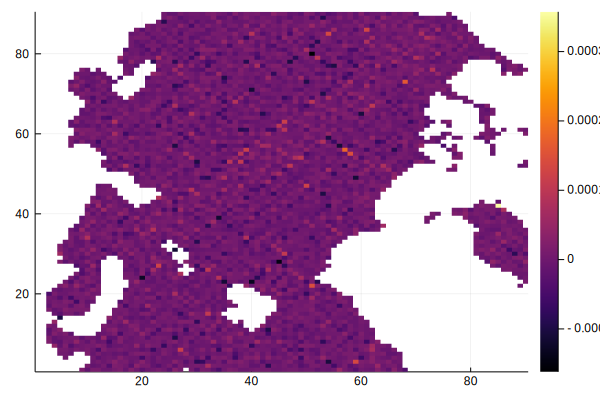

In [4]:
tmpCon=convergence(TxD,TyD)
tmp1=TrspCon[3]
tmp2=tmp1[findall(isfinite.(tmp1))]
errCon=1/sqrt(mean(tmp2.^2)).*(tmpCon[3]-TrspCon[3])
heatmap(errCon)

### Map Out Streamfunction And Scalar Potential

_Interpolation is used to create global maps_

In [5]:
TrspPsiI=MatrixInterp(write(1e-6*msk*TrspPsi),SPM,size(lon))
contourf(vec(lon[:,1]),vec(lat[1,:]),transpose(TrspPsiI),
    title="Streamfunction",clims=(-50,50))

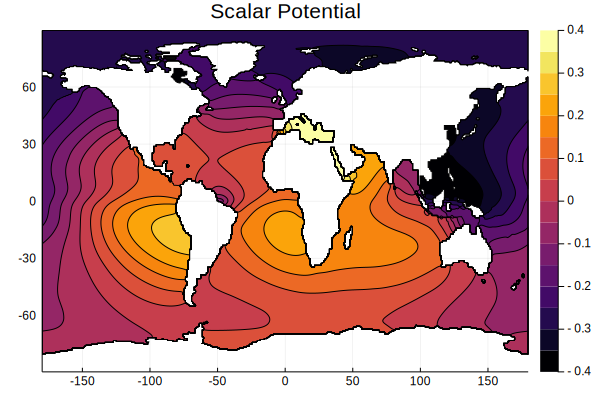

In [6]:
TrspPotI=MatrixInterp(write(1e-6*msk*TrspPot),SPM,size(lon))
contourf(vec(lon[:,1]),vec(lat[1,:]),transpose(TrspPotI),
    title="Scalar Potential",clims=(-0.4,0.4))